In [41]:
using PyPlot
using JuMP, Ipopt

In [42]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Make figures from default model configuration for manuscript

In [44]:
model = ClimateModel();
@time optimize_controls!(model);

  0.030377 seconds (44.48 k allocations: 2.123 MiB)


#### Approach 2: Avoiding damage thresholds

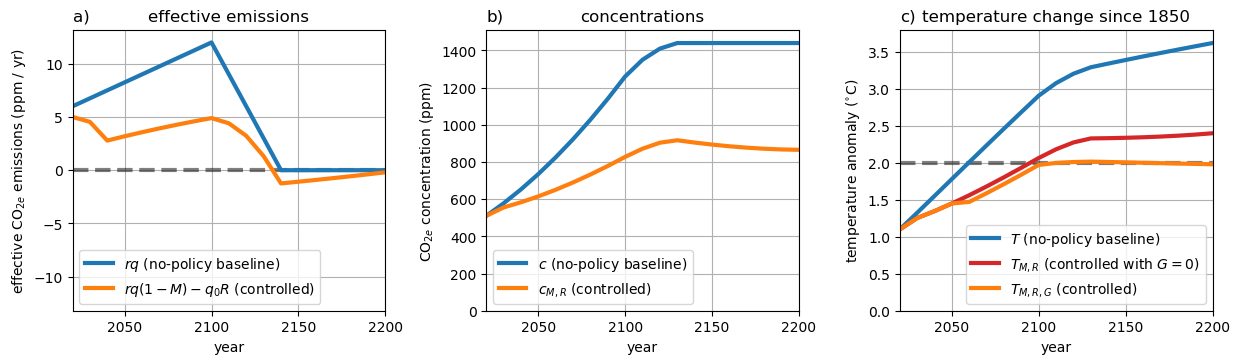

In [45]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
add_label("a)")
subplot(1,3,2)
plot_concentrations(model)
legend()
add_label("b)")
subplot(1,3,3)
plot_temperatures(model)
legend()
add_label("c)")
tight_layout()
savefig("../figures/default-temp_carbon_and_temperatures.png", dpi=200, bbox_inches="tight")

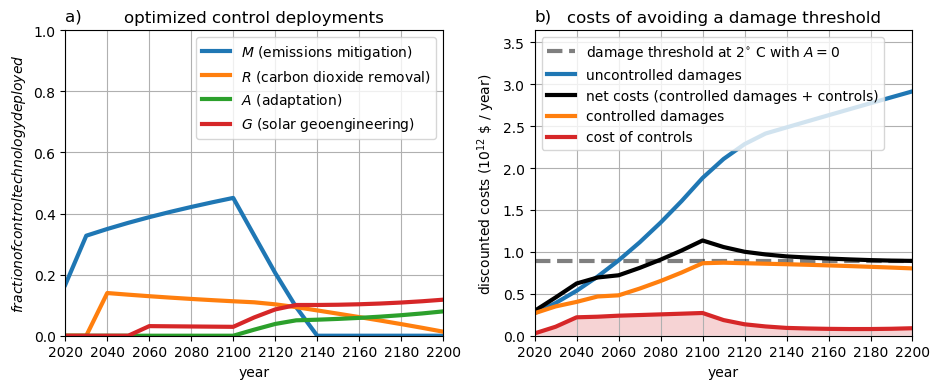

In [46]:
figure(figsize=(9.5,4.0))

subplot(1,2,1)
plot_controls(model)
legend()
add_label("a)")
subplot(1,2,2)
plot_damages(model)
legend()
add_label("b)")
tight_layout()
savefig("../figures/default-temp_controls_and_damages.png", dpi=200, bbox_inches="tight")

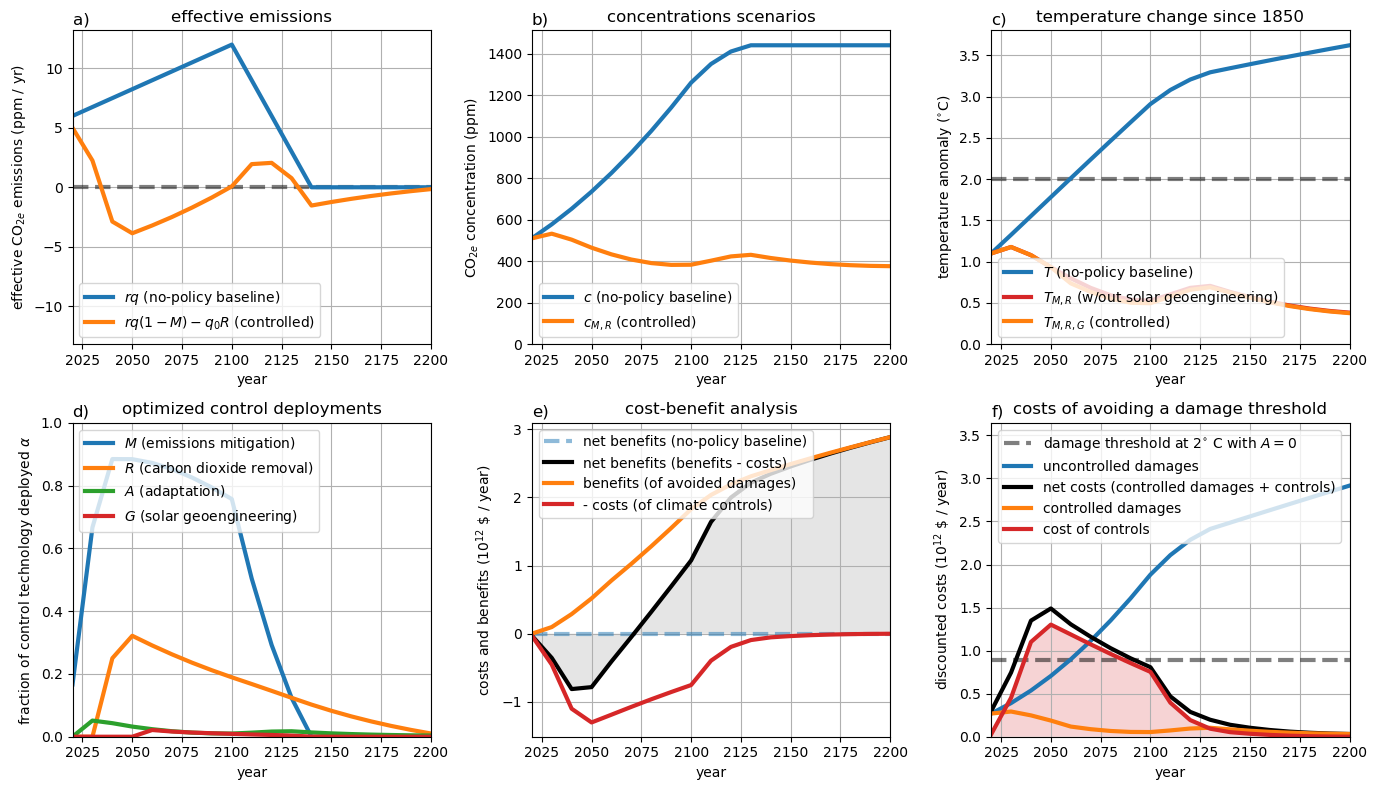

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      356
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      329

Total number of variables............................:      178
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      140
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [6]:
model = ClimateModel();
@time optimize_controls!(model, obj_option = "net_benefit");
plot_state(model);